### Classification Tree

In [1]:
library(tidyverse)
library(tree)
library(rsample)
library(ISLR2)
attach(Carseats)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
Carseats[1:2,]

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes


In [3]:
High <- factor(ifelse(Carseats$Sales <= 8, "No", "Yes"))
Carseats <- data.frame(Carseats, High)

In [4]:
Carseats[1:2, ]

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,Yes


In [5]:
tree.carseats <- tree(High ~ . -Sales, data = Carseats)

In [6]:
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

### Interpretation 
* training error rate is 9%
* Deviance closely related to entropy : small deviance, a tree that provides a good fit to training data

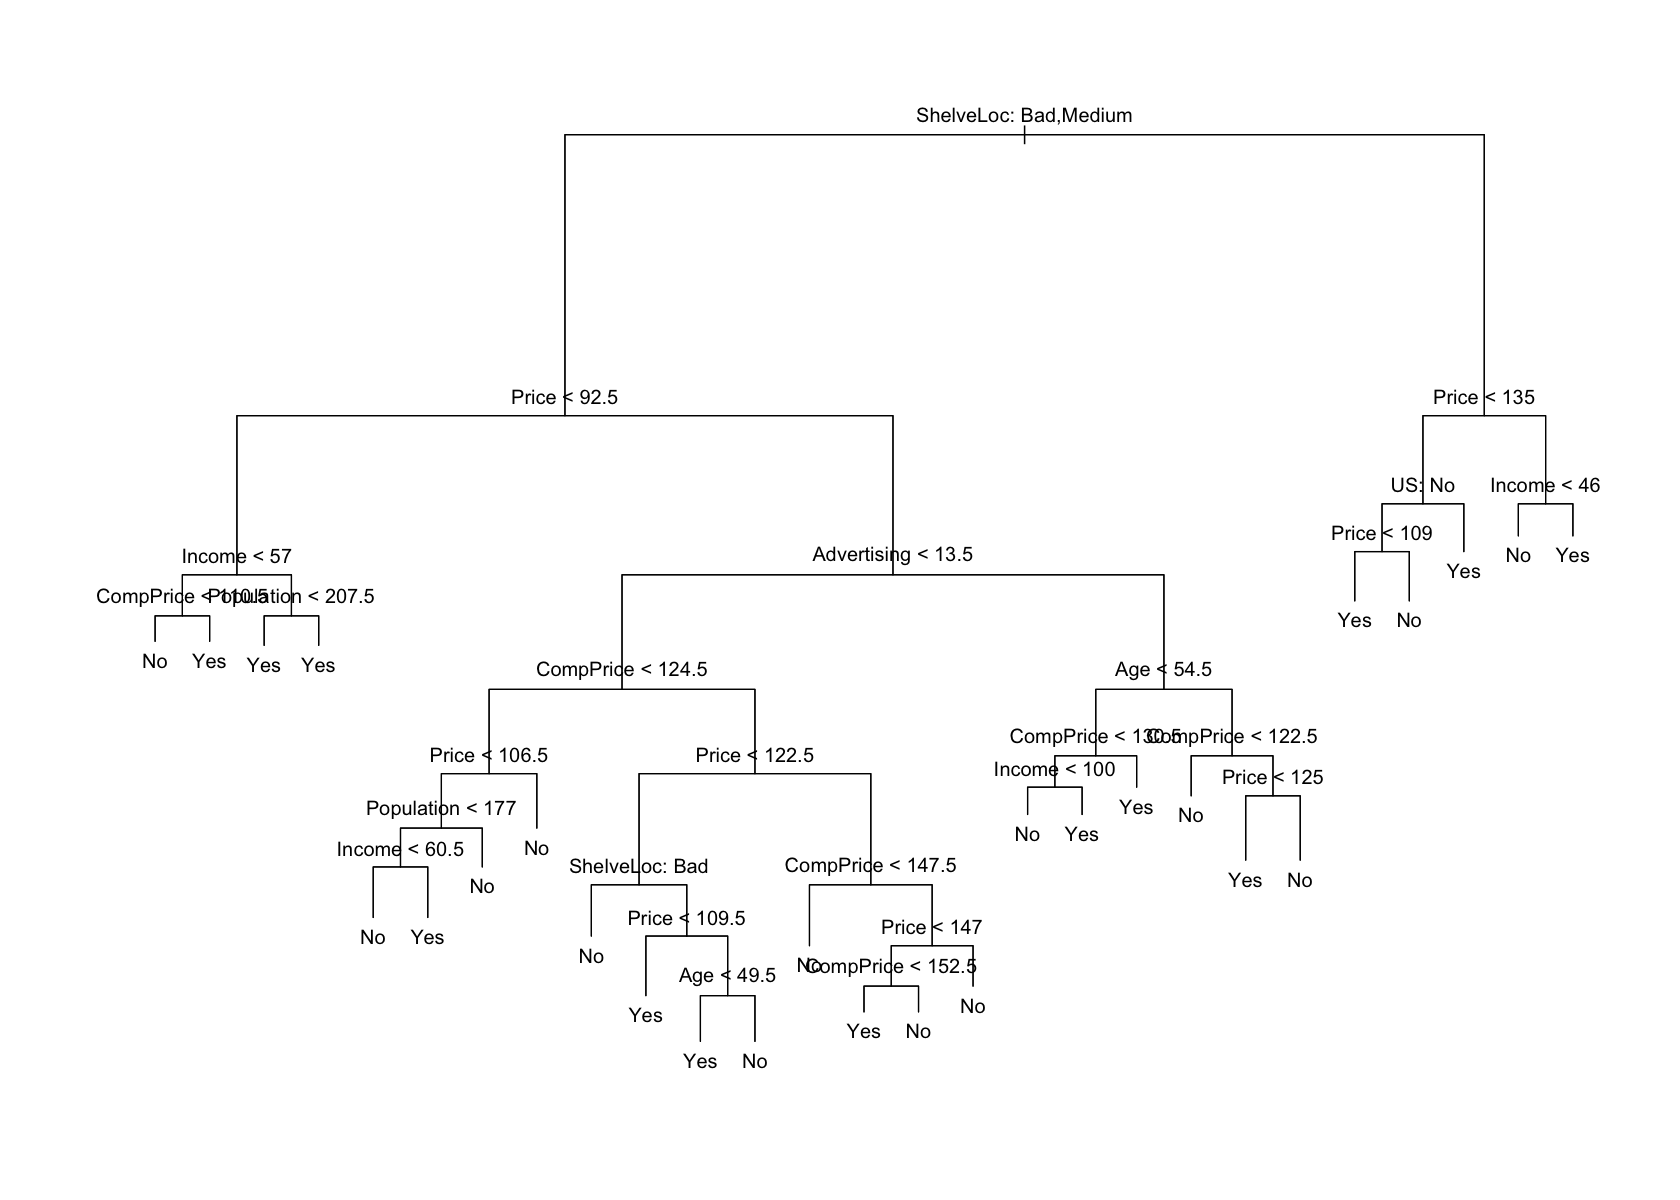

In [7]:
options(repr.plot.width = 14, repr.plot.height =10)

plot(tree.carseats)
text(tree.carseats, pretty = 0)

### Interpretation 
* most important indicator of Sales appears to be shelving location, since the first branch differentiates Good locations from Bad and Medium locations.

In [8]:
set.seed(2)
train <- sample(1:nrow(Carseats), 200)
Carseats.test <- Carseats[-train, ]
High.test <- High[-train]
tree.carseats <- tree(High ~ . - Sales, Carseats,
    subset = train)
tree.pred <- predict(tree.carseats, Carseats.test,
    type = "class")
table(tree.pred, High.test)

         High.test
tree.pred  No Yes
      No  104  33
      Yes  13  50

In [9]:
(104+50)/200

[1] 0.77

* Next, we consider whether **pruning the tree** might lead to improved results.
* The function cv.tree() performs cross-validation in order to determine the optimal level of tree complexity; cost complexity pruning is used in order to select a sequence of trees for consideration.
* use the argument **FUN = prune.misclass** in order to indicate that we want the **classification error rate** to guide the cross-validation and pruning process, rather than the default for the cv.tree() function, which is deviance.

In [10]:
set.seed(7)
cv.carseats <- cv.tree(tree.carseats, FUN = prune.misclass)

In [11]:
names(cv.carseats)

[1] "size"   "dev"    "k"      "method"

In [12]:
cv.carseats

$size
[1] 21 19 14  9  8  5  3  2  1

$dev
[1] 75 75 75 74 82 83 83 85 82

$k
[1] -Inf  0.0  1.0  1.4  2.0  3.0  4.0  9.0 18.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

* Despite its name, dev corresponds to the number of cross-validation errors.
* At 9 terminal nodes results in only 56 cross-validation errors (lowest). We plot the error rate as a function of both size and k.

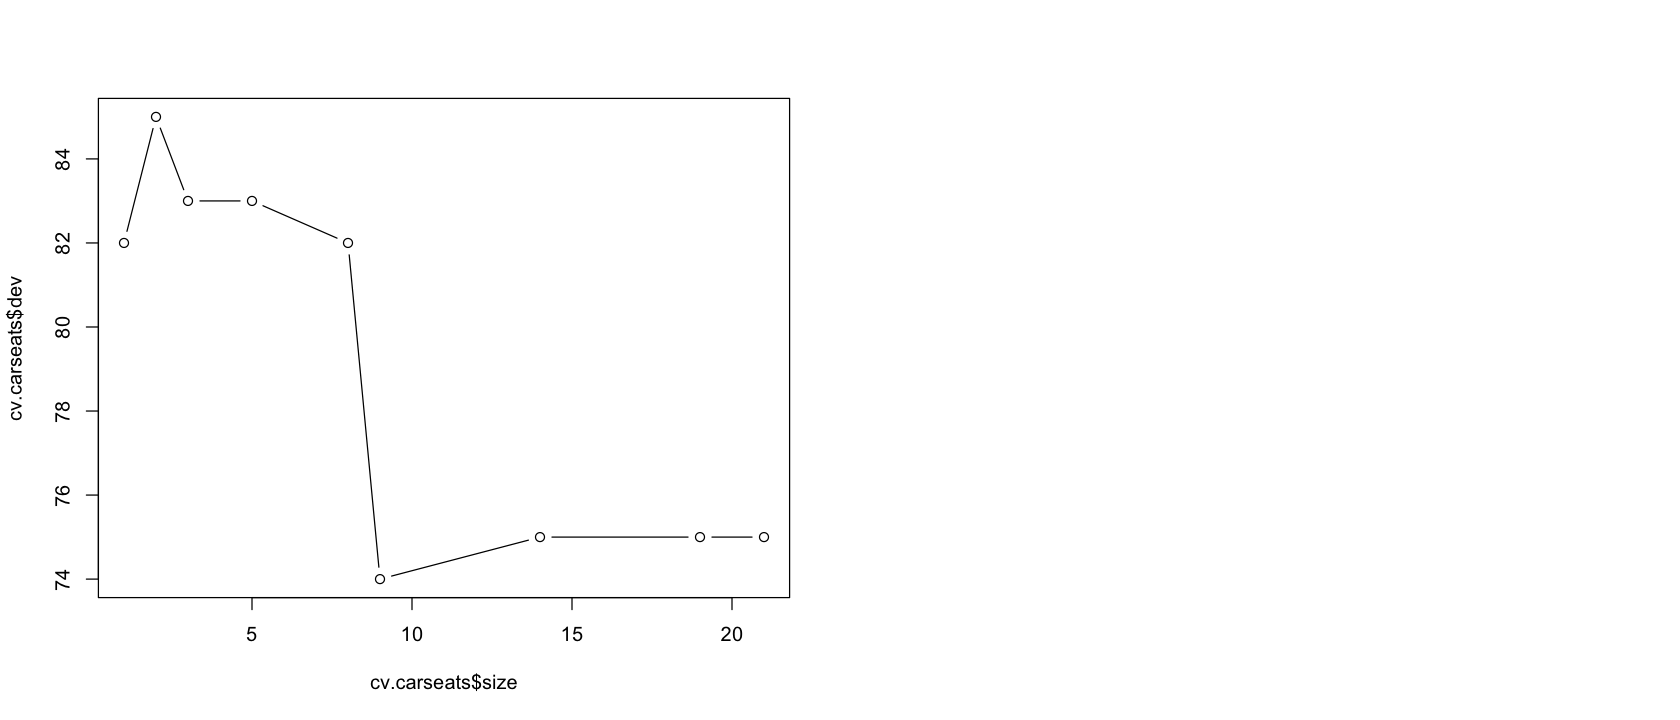

In [13]:
options(repr.plot.width = 14, repr.plot.height =6)
par(mfrow = c(1, 2))
plot(cv.carseats$size, cv.carseats$dev, type = "b")

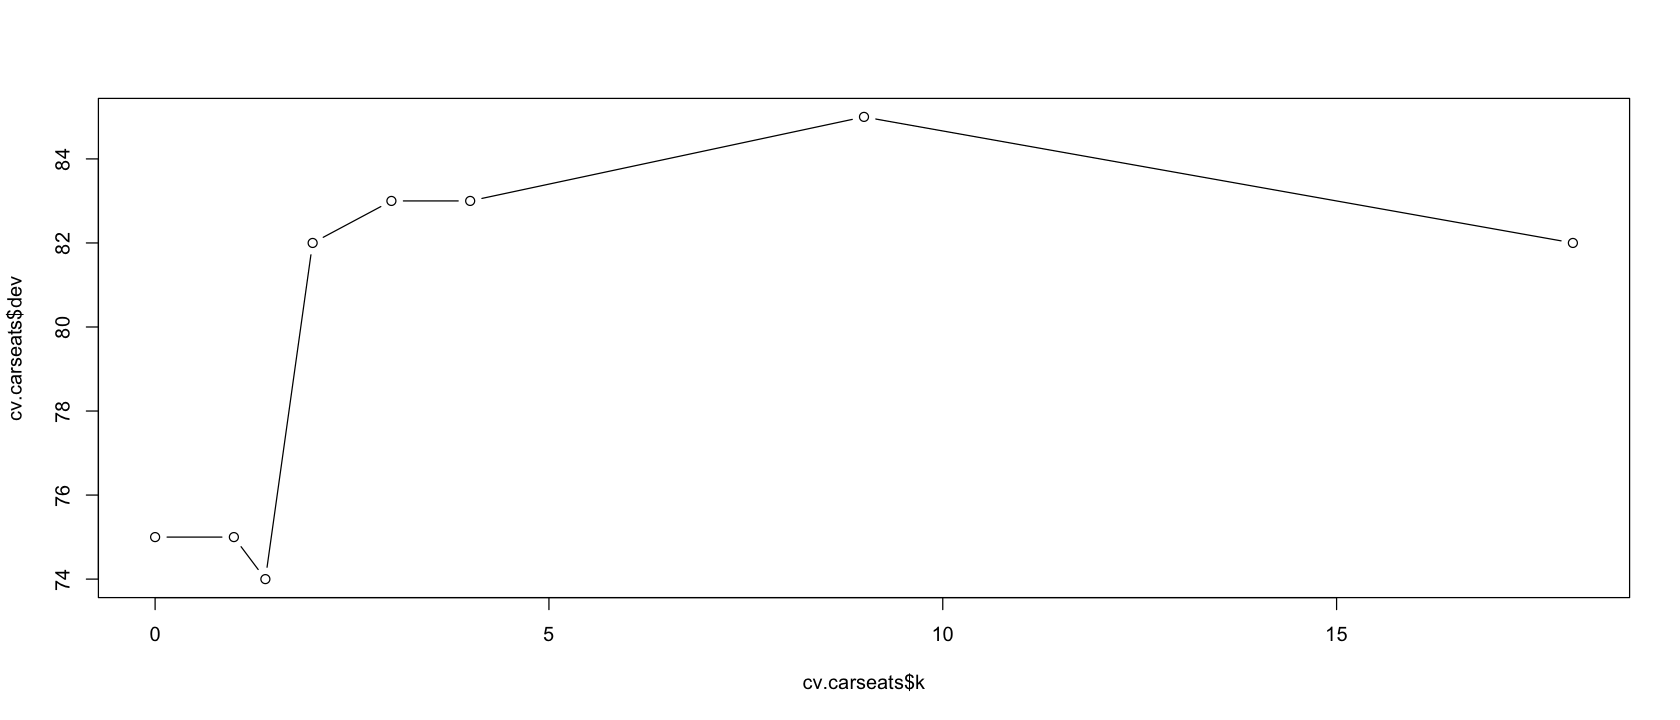

In [14]:
plot(cv.carseats$k, cv.carseats$dev, type = "b")

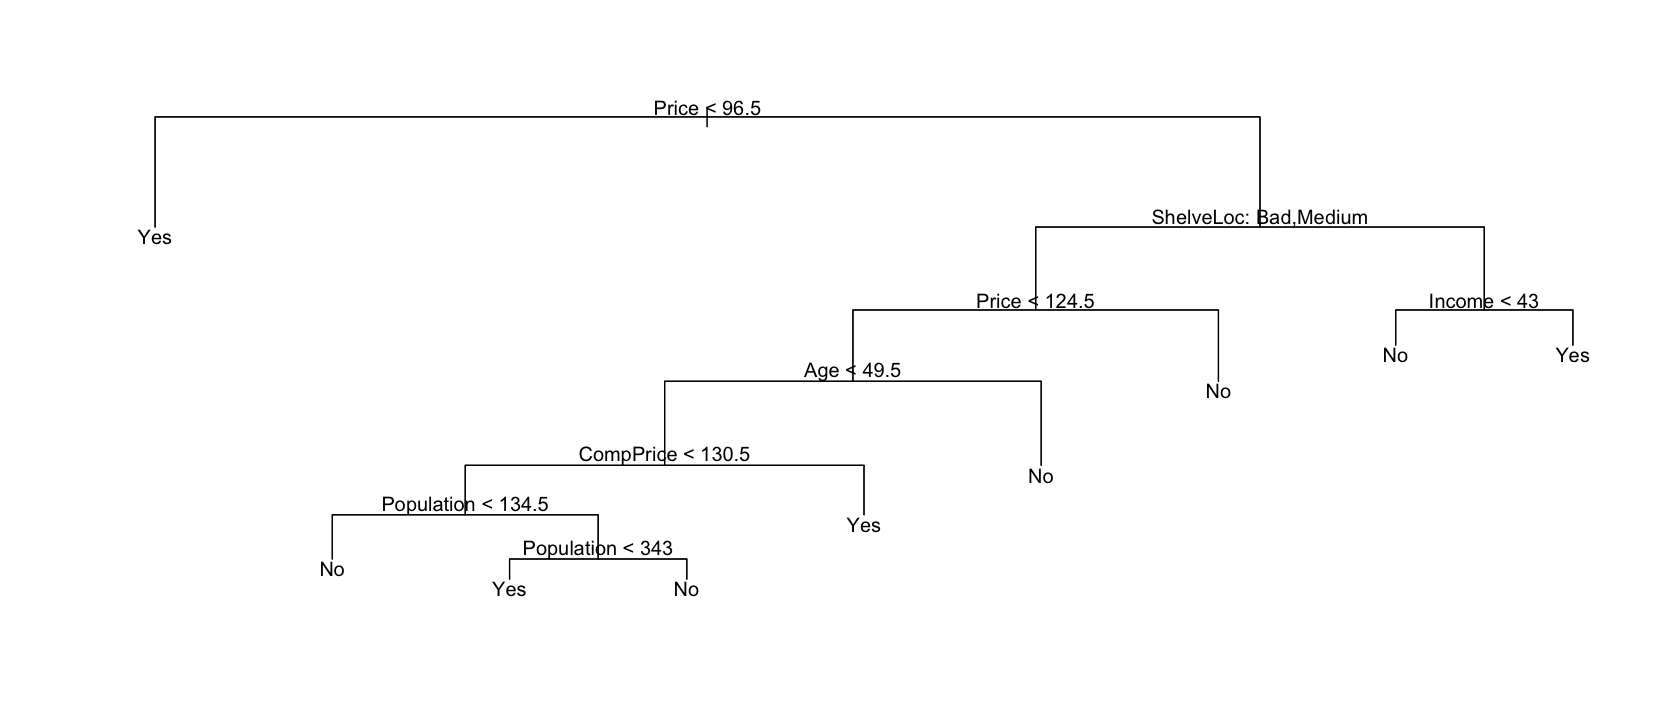

In [15]:
# Apply the prune.misclass() function in order to prune the tree to obtain the 11-node tree.
prune.carseats <- prune.misclass(tree.carseats, best = 9)
plot(prune.carseats)
text(prune.carseats, pretty = 0)


### How well does this pruned tree perform on the test data set?

In [21]:
tree.pred <- predict(prune.carseats, Carseats.test,
    type = "class")
table(tree.pred, High.test)


         High.test
tree.pred No Yes
      No  97  25
      Yes 20  58

In [23]:
(97+58)/200

[1] 0.775

### Regression Tree

In [28]:
set.seed(1)
train <- sample(1:nrow(Boston), nrow(Boston) / 2)

In [29]:
tree.boston <- tree(medv ~ ., Boston, subset = train)
summary(tree.boston)


Regression tree:
tree(formula = medv ~ ., data = Boston, subset = train)
Variables actually used in tree construction:
[1] "rm"    "lstat" "crim"  "age"  
Number of terminal nodes:  7 
Residual mean deviance:  10.38 = 2555 / 246 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-10.1800  -1.7770  -0.1775   0.0000   1.9230  16.5800 

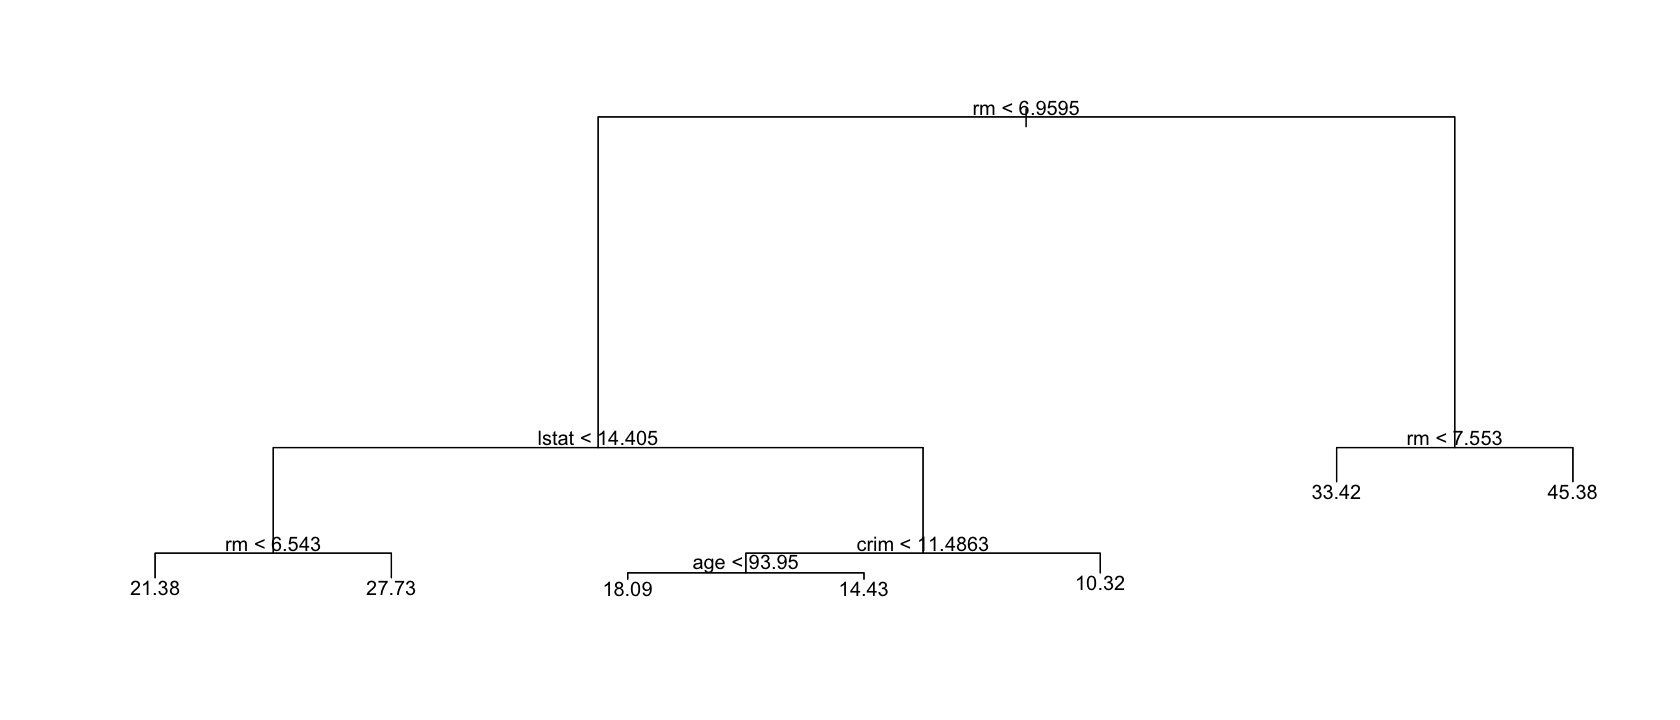

In [30]:
plot(tree.boston)
text(tree.boston, pretty = 0)


* Now we use the cv.tree() function to see whether pruning the tree will improve performance.

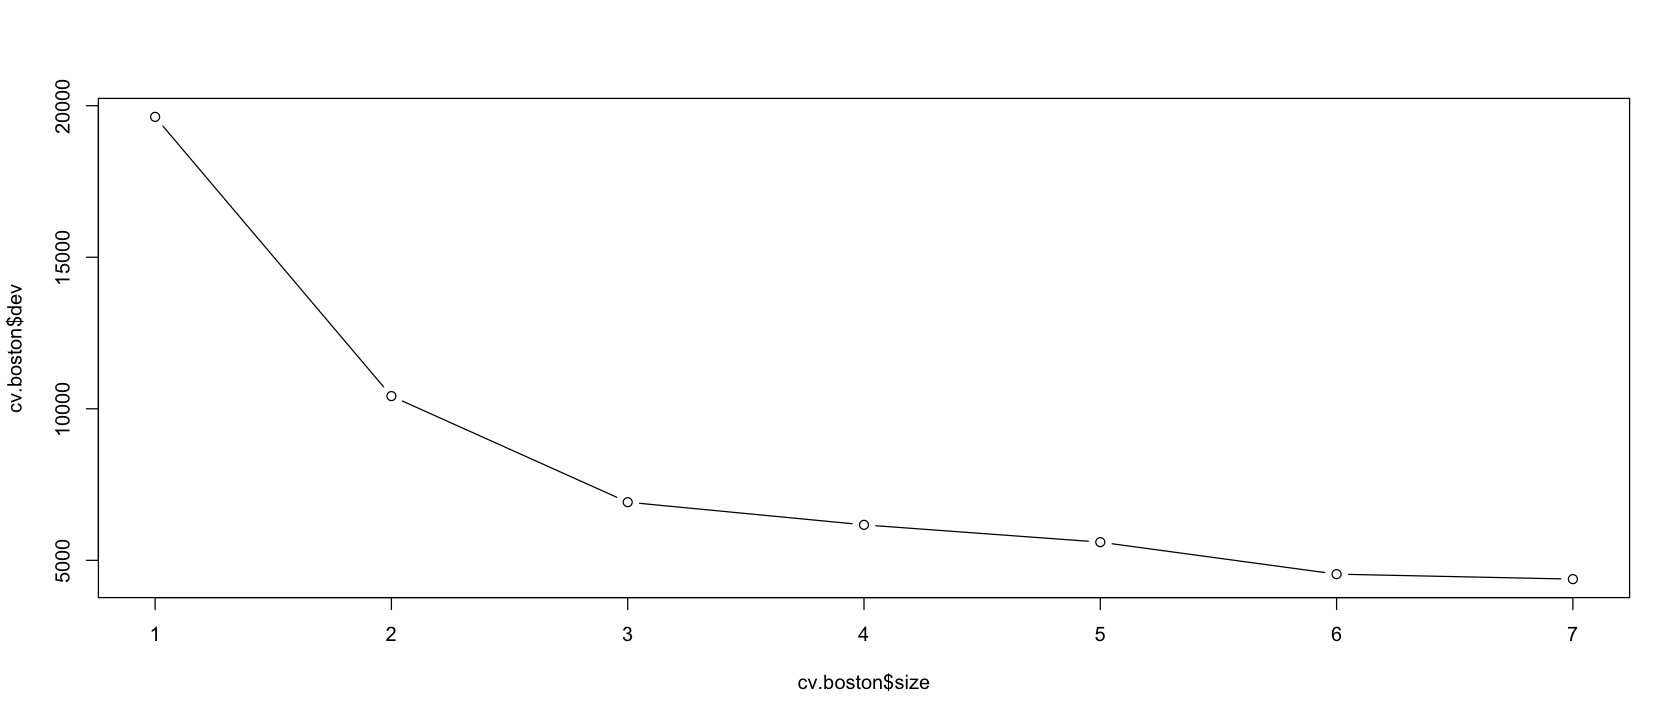

In [31]:
cv.boston <- cv.tree(tree.boston)
plot(cv.boston$size, cv.boston$dev, type = "b")

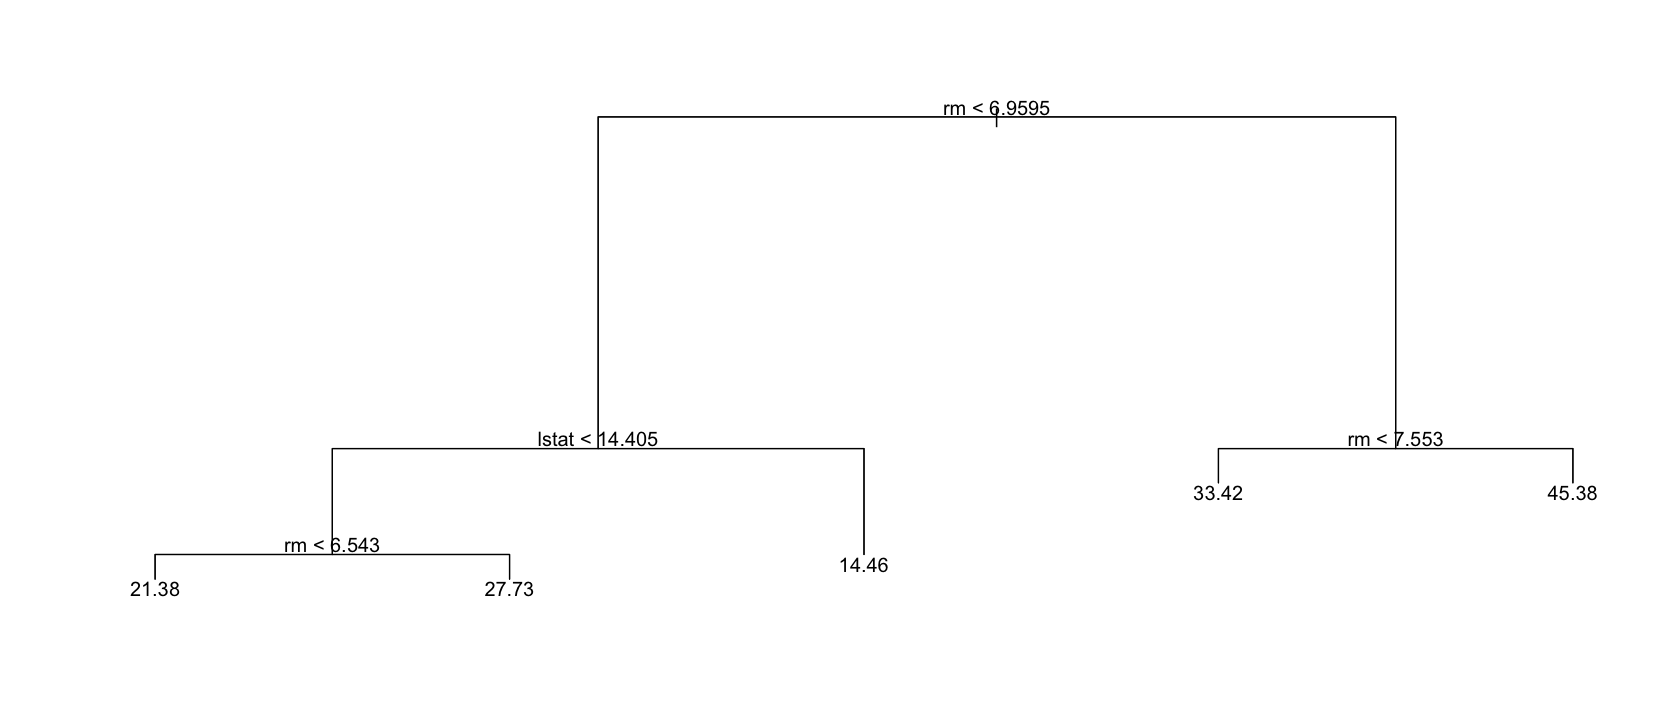

In [33]:
# use 5 terminal nodes for prune 
prune.boston <- prune.tree(tree.boston, best = 5)
plot(prune.boston)
text(prune.boston, pretty = 0)

* Prediction on test data

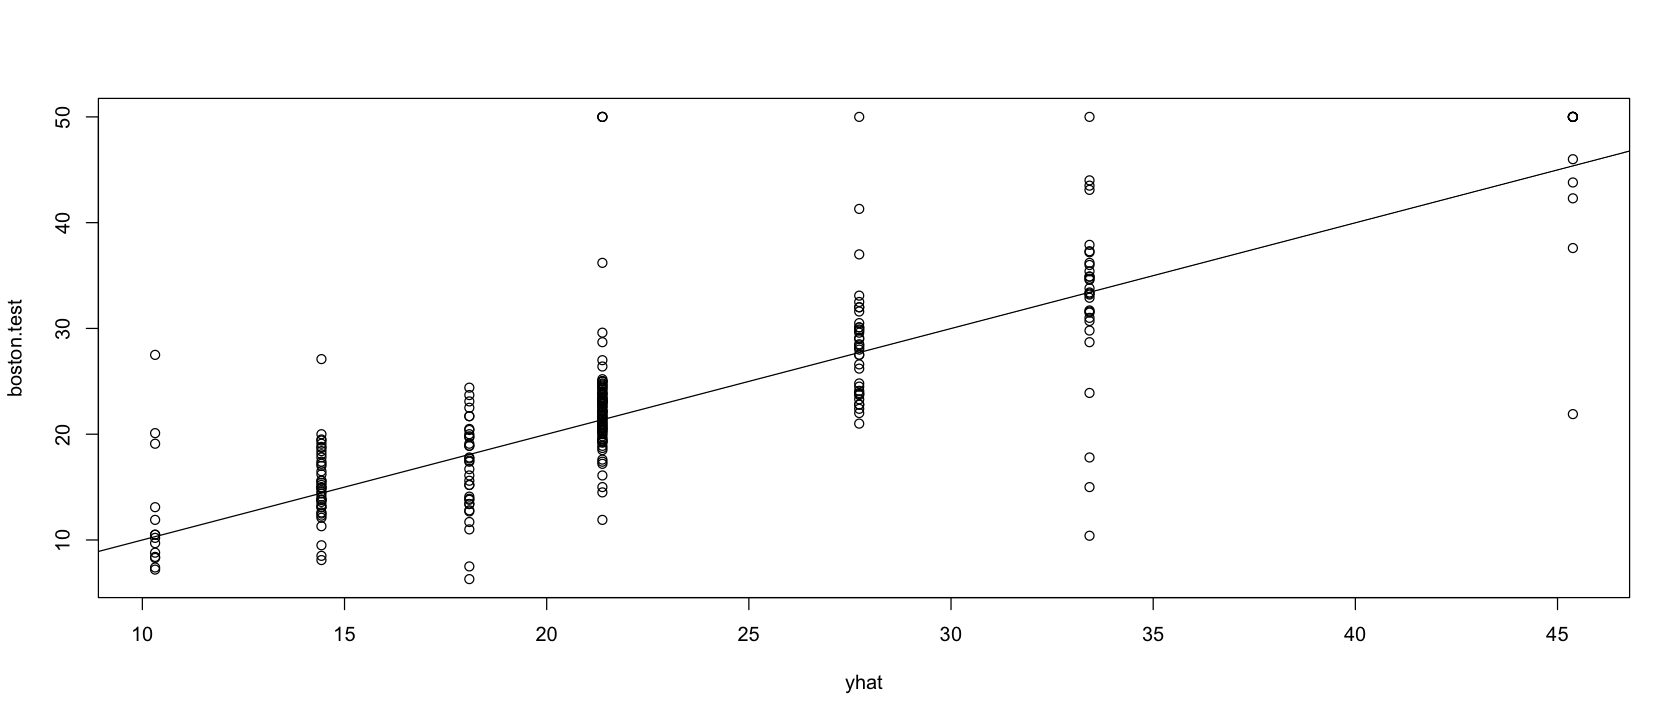

In [36]:
yhat <- predict(tree.boston, newdata = Boston[-train, ])
boston.test <- Boston[-train, "medv"]
plot(yhat, boston.test)
abline(0,1)